In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from collections import OrderedDict


import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import googlenet, vgg16, efficientnet_b0, resnet50
from torchsummary import summary
from torch import optim
from torchvision import transforms

# Define Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [4]:
google = googlenet()
vgg = vgg16()
res = resnet50()
effi = efficientnet_b0()

/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [5]:
class Attention_Layer(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.query_weight = nn.Linear(in_features, out_features, bias=False)
    self.key_weight = nn.Linear(in_features, out_features, bias=False)
    self.value_weight = nn.Linear(in_features, out_features, bias=False)
    #self.softmax = nn.Softmax(dim=-1)
    self.ReLU = nn.ReLU(inplace=True)
    self.out_projection = nn.Linear(out_features, out_features)
    
  def forward(self, x):
    query = self.query_weight(x)
    key = self.key_weight(x)
    value = self.value_weight(x)
        
    attention_score = torch.matmul(key.t(), query)
    #attention_score = self.softmax(attention_score)
    attention_score = self.ReLU(attention_score)
    attention_value = torch.matmul(value, attention_score)
    output = self.out_projection(attention_value)
    return output

class Modifiedmodel(nn.Module):
  def __init__(self, model, add_layer):
    super().__init__()
    self.model = copy.deepcopy(model)
    self.add_layer = add_layer
    self.layer_list = []

    # freeze all parameters
    for param in self.model.parameters():
      param.requires_grad = False
    
    # modify model
    for name, layer in self.model.named_children():
      if name == "avgpool":
        break
      else:
        self.layer_list.append(layer)
    
    self.features = nn.Sequential(*self.layer_list)
    self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.classifier = nn.Sequential(*self.add_layer)
    self.model = None

  def forward(self, x):
    x = self.features(x)
    x = self.gap(x)
    output = self.classifier(x)
    
    return output


In [6]:
add_layer_google = [
    nn.BatchNorm2d(num_features=1024, momentum=0.99),
    nn.Flatten(),
    nn.Linear(1024, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    Attention_Layer(32, 250),
    nn.Linear(250, 1),
    nn.Sigmoid()
    ]

google_atten = Modifiedmodel(model=google, add_layer=add_layer_google)

add_layer_vgg = [
    nn.BatchNorm2d(num_features=512, momentum=0.99),
    nn.Flatten(),
    nn.Linear(512, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    Attention_Layer(32, 250),
    nn.Linear(250, 1),
    nn.Sigmoid()
    ]

vgg_atten = Modifiedmodel(model=vgg, add_layer=add_layer_vgg)

add_layer_res = [
    nn.BatchNorm2d(num_features=2048, momentum=0.99),
    nn.Flatten(),
    nn.Linear(2048, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    Attention_Layer(32, 250),
    nn.Linear(250, 1),
    nn.Sigmoid()
    ]

res_atten = Modifiedmodel(model=res, add_layer=add_layer_res)

add_layer_effi = [
    nn.BatchNorm2d(num_features=1280, momentum=0.99),
    nn.Flatten(),
    nn.Linear(1280, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    Attention_Layer(32, 250),
    nn.Linear(250, 1),
    nn.Sigmoid()
    ]

effi_atten = Modifiedmodel(model=effi, add_layer=add_layer_effi)

# Dataset

In [7]:
test_path_1 = "/content/drive/MyDrive/fire_ds1/test"
test_path_2 = "/content/drive/MyDrive/fire_ds2/test"
test_path_3 = "/content/drive/MyDrive/fire_ds1/train" # imbalnced data in fire training set

batch_size = 32

In [8]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

fire_ds1 = ImageFolder(test_path_1, transform=transforms) # first
fire_ds2 = ImageFolder(test_path_2, transform=transforms) # second

fire_dl1 = DataLoader(fire_ds1, batch_size=batch_size, shuffle=False) # first
fire_dl2 = DataLoader(fire_ds2, batch_size=batch_size, shuffle=False) # second


# Load Proposed Model

In [9]:
vgg_mod = torch.load("/content/drive/MyDrive/VGG-16_mod_model.pt")
vgg_mod = vgg_mod.to(device)

res_mod = torch.load("/content/drive/MyDrive/Res-50_mod_model.pt")
res_mod = res_mod.to(device)


In [16]:
google_atten = torch.load("/content/drive/MyDrive/google_atten_model.pt")
google_atten = google_atten.to(device)

vgg_atten = torch.load("/content/drive/MyDrive/vgg_atten_model.pt")
vgg_atten = vgg_atten.to(device)

res_atten = torch.load("/content/drive/MyDrive/res_atten_model.pt")
res_atten = res_atten.to(device)

effi_atten = torch.load("/content/drive/MyDrive/effi_atten_model.pt")
effi_atten = effi_atten.to(device)

# Define Test Model

## test for first architecture

In [10]:
def test_for_first_archi(model, dataloader):
  was_training = model.training # save current mode
  correct = []
  y_true = []
  y_pred = []

  model.eval()
  with torch.no_grad():
    for data, label in dataloader:
      data, label = data.to(device), label.to(device)
             
      output = model(data)
      _, pred = torch.max(output, 1)
      #correct += torch.sum(pred == label.data)
      correct_mask = (pred == label.data)

      correct.extend(correct_mask.flatten().tolist())
      y_true.extend(label.data.flatten().tolist())
      y_pred.extend(pred.flatten().tolist())

  acc = sum(correct) / len(correct)
  model.train(mode=was_training) # back to previous mode
    
  return acc, y_true, y_pred

## test for second architecture

In [17]:
def test_for_second_archi(model, dataloader):
  was_training = model.training
  correct = []
  y_true = []
  y_pred = []

  threshold = torch.tensor(0.5)
    
  model.eval()
  with torch.no_grad():
    for data, label in dataloader:
      data, label = data.to(device), label.to(device)
      label = label.float()
      label = torch.unsqueeze(label, dim=1)
            
      output = model(data)
            
      pred = output > threshold
      #correct += torch.sum(pred == label.data)

      correct_mask = (pred == label.data)

      correct.extend(correct_mask.flatten().tolist())
      y_true.extend(label.data.flatten().tolist())
      y_pred.extend(pred.flatten().tolist())

  acc = sum(correct) / len(correct)

  model.train(mode=was_training)
    
  return acc, y_true, y_pred

# Testing

## first architecture in second ds

In [11]:
vgg_mod_acc, vgg_mod_true, vgg_mod_pred = test_for_first_archi(vgg_mod, fire_dl2)
res_mod_acc, res_mod_true, res_mod_pred = test_for_first_archi(res_mod, fire_dl2)

print(f"Acc for first modified VGG-16 in second dataset: {vgg_mod_acc:.2f}")
print(f"Acc for first modified Res-50 in second dataset: {res_mod_acc:.2f}")

Acc for first modified VGG-16 in second dataset: 0.92
Acc for first modified Res-50 in second dataset: 0.98


## secondt architecture in first ds

In [18]:
google_atten_acc, google_atten_true, google_atten_pred = test_for_second_archi(google_atten, fire_dl1)
vgg_atten_acc, vgg_atten_true, vgg_atten_pred = test_for_second_archi(vgg_atten, fire_dl1)
res_atten_acc, res_atten_true, res_atten_pred = test_for_second_archi(res_atten, fire_dl1)
effi_atten_acc, effi_atten_true, effi_atten_pred = test_for_second_archi(effi_atten, fire_dl1)

print(f"Acc for GoogLeNet with attention in first dataset: {google_atten_acc:.2f}")
print(f"Acc for VGG-16 with attention in first dataset: {vgg_atten_acc:.2f}")
print(f"Acc for ResNet-50 with attention in first dataset: {res_atten_acc:.2f}")
print(f"Acc for EfficientNet_B0 with attention in first dataset: {effi_atten_acc:.2f}")

Acc for GoogLeNet with attention in first dataset: 0.93
Acc for VGG-16 with attention in first dataset: 0.96
Acc for ResNet-50 with attention in first dataset: 0.98
Acc for EfficientNet_B0 with attention in first dataset: 0.98


# Confusion matrix

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
  matrix = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = matrix.ravel()

  xlabel = ["Non Fire", "Fire"]
  ylabel = ["Non Fire", "Fire"]
  sns.heatmap(matrix, square=True, annot=True, cmap="YlGn", fmt="d", xticklabels=xlabel, yticklabels=ylabel)
  plt.title(title)
  plt.xlabel("Predicted label")
  plt.ylabel("True label")

  precision = tp / (tp+fp)
  recall = tp / (tp + fn)
  f1_score = 2 * ((precision*recall) / (precision+recall))
  
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1_score:.4f}")


## vgg mod

Precision: 1.0000
Recall: 0.8338
F1-score: 0.9093


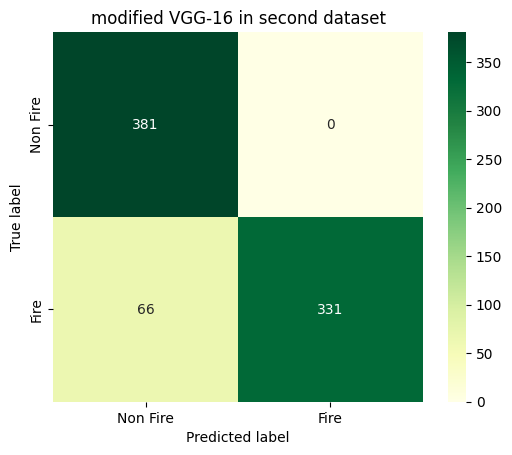

In [14]:
plot_confusion_matrix(vgg_mod_true, vgg_mod_pred, title="modified VGG-16 in second dataset")

## res mod

Precision: 0.9872
Recall: 0.9748
F1-score: 0.9810


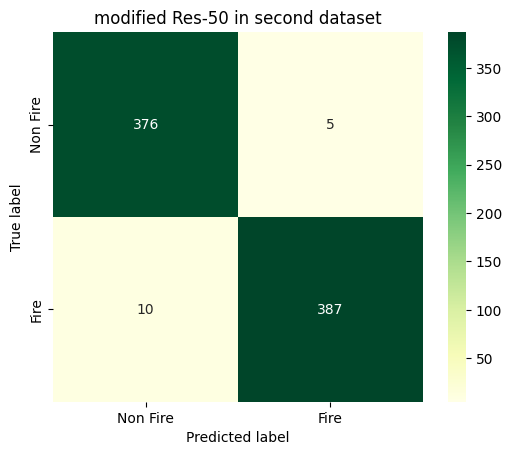

In [15]:
plot_confusion_matrix(res_mod_true, res_mod_pred, title="modified ResNet-50 in second dataset")

## google

Precision: 0.9783
Recall: 0.8824
F1-score: 0.9278


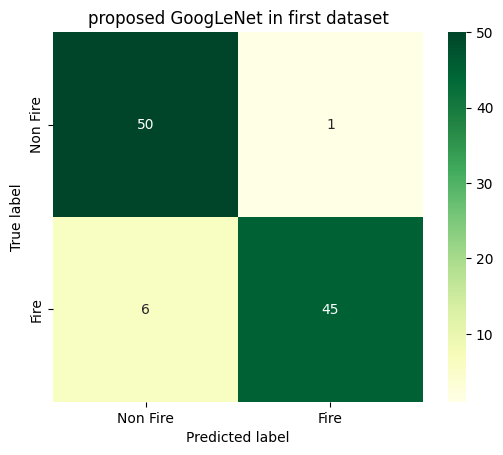

In [19]:
plot_confusion_matrix(google_atten_true, google_atten_pred, title="proposed GoogLeNet in first dataset")

## vgg

Precision: 0.9796
Recall: 0.9412
F1-score: 0.9600


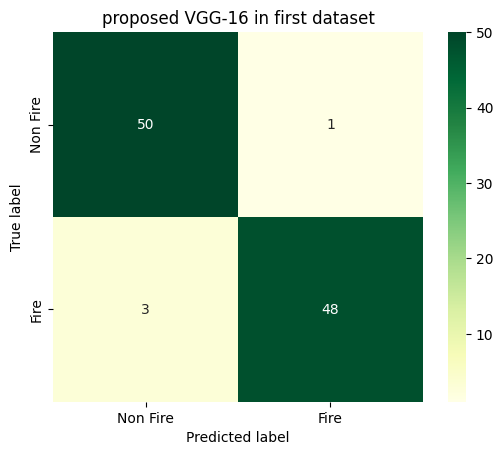

In [20]:
plot_confusion_matrix(vgg_atten_true, vgg_atten_pred, title="proposed VGG-16 in first dataset")

## resnet

Precision: 0.9804
Recall: 0.9804
F1-score: 0.9804


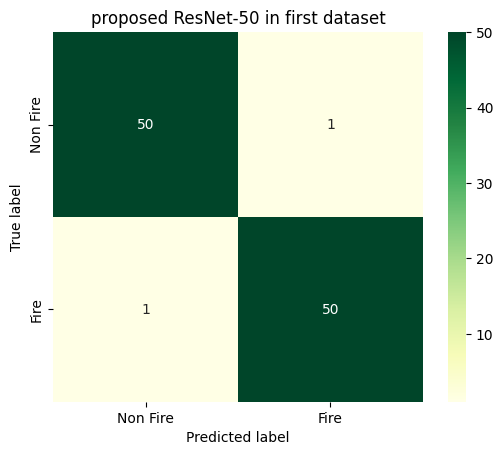

In [21]:
plot_confusion_matrix(res_atten_true, res_atten_pred, title="proposed ResNet-50 in first dataset")

## efficientb0

Precision: 0.9804
Recall: 0.9804
F1-score: 0.9804


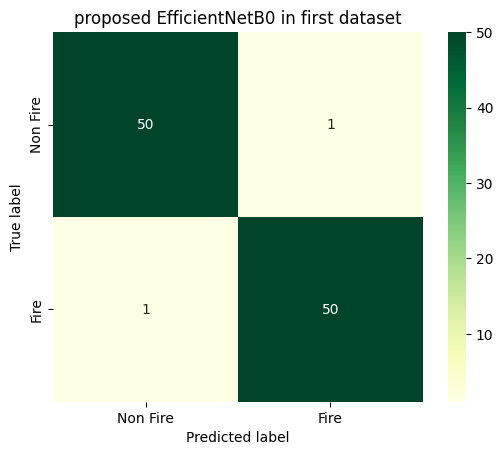

In [22]:
plot_confusion_matrix(effi_atten_true, effi_atten_pred, title="proposed EfficientNetB0 in first dataset")